
# **Cuaderno de Proyecto — Ciencia de Datos con YouTube**
**Curso:** SINT-200  
**Profesor:** Dr. Tomás de Camino Beck  
**Estudiante(s):** _Bernal Rojas Villalobos_  
**Fecha de entrega:** 21 de Octubre

---

## Instrucciones Generales

Reto: Exportar datos de tu actividad YouTube (Google Takeout), construir una matriz usuario-contenido con señales (vistas, likes, tiempo, etc.), hacer EDA de sesgos/“burbujas”, y entrenar dos recomendadores (colaborativo vs. basado en contenido). Comparar métricas (cosas como precision@k, recall@k, cobertura) y explicar errores.  



Este cuaderno sirve como **especificación y entregable** del proyecto. Debes completar cada sección marcada con **TODO** y dejar celdas de código **ejecutables** y **reproducibles**. El reto tiene dos proyectos:

1. **Proyecto 1 — Tu Huella YouTube: Recomendador y Análisis de Burbuja Algorítmica.**  
2. **Proyecto 2 — Detección de “Doomscrolling”: Predicción de sesiones extendidas.**

### Ética y Privacidad de Datos
- Puedes **anonimizar** tu información de YouTube (IDs, títulos, canales, tiempos) antes de subirla aquí.  
- Alternativamente, puedes usar datos de otra persona **con su consentimiento informado** y **anonimizados**.  
- No incluyas PII (información personal identificable) ni material sensible.  
- Incluye un **Anexo de Privacidad** explicando qué datos usaste, cómo los obtuviste y cómo los protegiste.

### Entregables
- Este **cuaderno de Colab** completo y ejecutable.  
- Carpeta `data/` con **muestras** de los datos (o datos sintéticos/anonimizados).  
- **Diccionario de datos** (descripción de campos, tipos, unidades, supuestos).  
- **Resultados y visualizaciones** dentro del notebook.  
- **Conclusiones** + **Recomendaciones** (acciones sugeridas) + **Limitaciones** + **Trabajo futuro**.
- Repositorio con estructura mínima:  
  ```
  README.md
  data/        # muestras o datos anonimizados
  notebooks/   # este cuaderno
  src/         # funciones reutilizables
  reports/     # figuras / tablas clave
  ```

### Rúbrica (100 pts)
- **Charter/Problema y utilidad (10 pts)**: objetivos claros, hipótesis, valor para el usuario.  
- **Adquisición y calidad de datos (10 pts)**: trazabilidad, permisos, limpieza básica.  
- **EDA y visualizaciones (20 pts)**: distribución, outliers, correlaciones, sesgos/segmentos.  
- **Baselines y metodología (10 pts)**: definición de referencia simple y por qué.  
- **Modelado (20 pts)**: al menos **2 enfoques** comparados, justificación.  
- **Evaluación (15 pts)**: métricas adecuadas, validación (temporal cuando aplique), error analysis.  
- **Reproducibilidad (5 pts)**: semillas, funciones, estructura clara.  
- **Conclusiones & ética (10 pts)**: hallazgos accionables y reflexiones de privacidad/sesgo.

---



## 0. Preparación del entorno (ejecutar una vez)


In [1]:
# Clonar tu repositorio
!git clone https://github.com/brojas7/AnaliticaHistorialYoutube.git

# Ir al directorio del proyecto
%cd AnaliticaHistorialYoutube

# TODO: Ajusta versiones si lo necesitas. Evita dependencias innecesarias.
!pip -q install pandas numpy matplotlib scikit-learn textblob python-dateutil tqdm dateparser google-generativeai  gensim

Cloning into 'AnaliticaHistorialYoutube'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 181 (delta 32), reused 4 (delta 1), pack-reused 110 (from 1)
Receiving objects: 100% (181/181), 45.39 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/AnaliticaHistorialYoutube
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 18.8 MB/s eta 0:00:00


In [2]:
# Imports base y configuración
import os, json, math, random, itertools, collections, gzip, re, string, time, zipfile, io
from datetime import datetime, timedelta
from dateutil import parser as dateparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)

import sys
sys.path.append('/content/AnaliticaHistorialYoutube/src')

from youtube_utils import load_watch_history, anonymize_df, sessionize

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 200)

print("Entorno listo. Versión de pandas:", pd.__version__)


Entorno listo. Versión de pandas: 2.2.2



## 1. Anexo de Privacidad y Origen de Datos (obligatorio)
**TODO:** Explicar:
- Fuente de datos (Google Takeout, exportación manual, datos de tercero con consentimiento, etc.).  
- Estrategia de **anonimización** (por ejemplo: hashing de IDs/URLs, truncado de timestamps, agrupación por hora/día).  
- Contenido eliminado o agregado (p. ej., datos sintéticos para completar campos).  
- Limitaciones y riesgos residuales.



## 2. Selección de Proyecto
**Marca con una X**

- [ ] **Proyecto 1 — Recomendador YouTube & Burbuja Algorítmica**  
- [ ] **Proyecto 2 — Detección de Doomscrolling (clasificación temporal)**



## 3. Utilidades comunes para YouTube (ingesta y parsing)

Para **Proyecto 1** y **Proyecto 2** puedes usar datos de **Google Takeout**:  
- `watch-history.json` (o `watch-history.html` en exportaciones antiguas)  
- `search-history.json` (opcional)  
- `likes.csv` / `subscriptions.csv` (según disponibilidad)

> **Nota:** Los formatos de Takeout pueden cambiar con el tiempo. Ajusta el parser según tu exportación.



# **Limpieza, Enriquecimiento y Transformación del dataset**


In [ ]:
# Ejemplo de uso
df_search = load_watch_history('data/historial-de-búsqueda.json')
df_watch = load_watch_history('data/historial-de-reproducciones.json')
df_suscipciones = pd.read_csv('data/suscripciones.csv')

#df = anonymize_df(df)
#df = sessionize(df)
print(df_search.shape)
print(df_watch.shape)
print("Eventos:", len(df_watch), "Rango:", df_watch['timestamp'].min(), "->", df_watch['timestamp'].max())

In [ ]:
# Copia base
df_watch_clean = df_watch.copy()

# Limpieza del título (remover "Has visto")
df_watch_clean['video_title'] = df_watch_clean['title'].str.replace(r'^Has visto\s+', '', regex=True)

# Convertir timestamps
df_watch_clean['watched_at'] = pd.to_datetime(df_watch_clean['timestamp'], utc=True)

# Variables derivadas
df_watch_clean['weekday'] = df_watch_clean['watched_at'].dt.day_name()
df_watch_clean['hour'] = df_watch_clean['watched_at'].dt.hour
df_watch_clean['hour_group'] = pd.cut(df_watch_clean['hour'],
                                      bins=[-1,6,12,18,24],
                                      labels=['madrugada','mañana','tarde','noche'])

In [ ]:
df_suscripciones_clean = df_suscipciones.rename(columns={
    "Título del canal": "channel_title",
    "URL del canal": "channel_url",
    "ID del canal": "channel_id"
})

In [ ]:
df_search_clean = df_search.copy()
df_search_clean['timestamp'] = pd.to_datetime(df_search_clean['timestamp'], utc=True)
df_search_clean['search_terms'] = df_search_clean['title'].str.replace('Buscaste', '').str.strip()

Enlace entre vistas y suscripciones

In [ ]:
# Renombramos la columna 'channel' en el historial para igualarla con suscripciones
df_watch_clean = df_watch_clean.rename(columns={'channel': 'channel_title'})

df_main = df_watch_clean.merge(
    df_suscripciones_clean[['channel_title', 'channel_id']],
    on='channel_title',
    how='left',
    indicator=True
)

df_main['is_subscribed'] = (df_main['_merge'] == 'both').astype(int)
df_main.drop(columns=['_merge'], inplace=True)

3️Señales de interacción (para matriz usuario–contenido)

In [ ]:
df_main['interaction_score'] = 1.0
df_main.loc[df_main['is_subscribed'] == 1, 'interaction_score'] += 0.5

Valores nulos en canal
son anuncios i videos borrados

In [ ]:
df_main.shape

In [ ]:
df_main[df_main['channel_title'].isna()][['video_title', 'url']].head(10)


In [ ]:
mask_valid = df_main['channel_title'].notna() & ~df_main['video_title'].str.contains("anuncio", case=False, na=False)
df_main_clean = df_main[mask_valid].copy()

In [ ]:
df_ads = df_main[~mask_valid]
df_ads.to_csv("data/df_ads_removed.csv", index=False)

ANON


# **Proyecto 1 — Tu Huella YouTube: Recomendador & Burbuja Algorítmica**

### Objetivo
1) Construir **dos recomendadores** con tus datos de visualización:  
   - **Baseline de popularidad** (o popularidad por canal/categoría).  
   - **Modelo basado en contenido** (TF‑IDF/embeddings por título/canal) **o** **colaborativo** (si tienes interacciones de múltiples usuarios/fuentes).  
2) Medir **Precision@k, Recall@k y Coverage** (y *diversidad*) en un esquema **offline**.  
3) Analizar posibles **sesgos o “burbujas”** (temas/canales dominantes por hora, día, duración).  

### Requisitos mínimos
- **EDA**: distribución de vistas por canal, hora del día, día de semana, duración de sesiones, *top‑k* temas.  
- **Ingeniería de features** (ej.: tokenización títulos, lematización opcional, normalización de canales).  
- **Comparación de al menos 2 enfoques** de recomendación.  
- **Evaluación offline** con *train/test split temporal*.  
- **Análisis de errores** y discusión de sesgos/limitaciones.

---

## 4. Charter del Proyecto 1 (llenar)
**TODO:** Define el propósito, preguntas clave y utilidad (qué decisiones permitirán tus hallazgos).



## 5. Carga de datos (Proyecto 1)
**TODO:** Sube tu `watch-history.json` (anonimizado si aplica) a `data/` y cárgalo.


In [3]:
df_main = pd.read_csv("data/df_enrich_enriquecido.csv")
print(df_main.shape)
df_main.head()

(31217, 18)


timestamp  \
0  2018-02-22 02:05:35.427000+00:00   
1  2018-02-22 03:49:54.096000+00:00   
2  2018-02-22 05:27:06.367000+00:00   
3  2018-02-22 06:26:38.438000+00:00   
4  2018-02-22 14:20:32.963000+00:00   

                                               title  \
0  Has visto La canción más hermosa en piano fáci...   
1  Has visto Ed Sheeran - Perfect - EASY Piano Tu...   
2  Has visto How I proposed: fairytale story with...   
3  Has visto TOP 5 BROMAS - Bromas para hacer a t...   
4                  Has visto Morat - Yo Más Te Adoro   

                       channel_title  channel_id_x     video_id  \
0  Paula Yessenia Barragan Izquierdo           NaN  ro1rC9dL5EQ   
1                       Peter PlutaX           NaN  p1WCR7vNcIw   
2                   bigchewypretzels           NaN  Srw9gXDa24g   
3               BROMAS Y MÁS TVOAQUI           NaN  Q4UilByqMTc   
4                          MoratVEVO           NaN  pqJBXjzBr_U   

                                           url  \
0  https://www.youtube.com/watch?v=ro1rC9dL5EQ   
1  https://www.youtube.com/watch?v=p1WCR7vNcIw   
2  https://www.youtube.com/watch?v=Srw9gXDa24g   
3  https://www.youtube.com/watch?v=Q4UilByqMTc   
4  https://www.youtube.com/watch?v=pqJBXjzBr_U   

                                         video_title  \
0  La canción más hermosa en piano fácil de aprender   
1  Ed Sheeran - Perfect - EASY Piano Tutorial by ...   
2  How I proposed: fairytale story with puzzles a...   
3  TOP 5 BROMAS - Bromas para hacer a tus amigos,...   
4                            Morat - Yo Más Te Adoro   

                         watched_at   weekday  hour hour_group channel_id_y  \
0  2018-02-22 02:05:35.427000+00:00  Thursday     2  madrugada          NaN   
1  2018-02-22 03:49:54.096000+00:00  Thursday     3  madrugada          NaN   
2  2018-02-22 05:27:06.367000+00:00  Thursday     5  madrugada          NaN   
3  2018-02-22 06:26:38.438000+00:00  Thursday     6  madrugada          NaN   
4  2018-02-22 14:20:32.963000+00:00  Thursday    14      tarde          NaN   

   is_subscribed  interaction_score       category                 subtopic  \
0              0                1.0       Tutorial             Music Lesson   
1              0                1.0       Tutorial             Music Lesson   
2              0                1.0  Entertainment  Relationship/Life Event   
3              0                1.0  Entertainment             Comedy/Prank   
4              0                1.0          Music        Music Performance   

                 format                                           keywords  
0              Tutorial         ['piano', 'easy to learn', 'music lesson']  
1              Tutorial  ['Ed Sheeran', 'Perfect', 'piano tutorial', 'e...  
2     Vlog/Storytelling  ['proposal', 'love story', 'fairytale', 'relat...  
3     Prank Compilation  ['pranks', 'friends', "Valentine's Day", 'come...  
4  Official Music Video  ['Morat', 'Yo Más Te Adoro', 'Latin Pop', 'Off...

In [ ]:
import hashlib
import pandas as pd
import numpy as np

def hash_value(x):
    """Aplica hash SHA-256 truncado (12 chars) a cualquier valor."""
    if pd.isna(x):
        return np.nan
    return hashlib.sha256(str(x).encode()).hexdigest()[:12]

# Copia del dataframe original
df_hashed = df_main.copy()

# Aplica el hash a todo el dataframe
df_hashed = df_hashed.applymap(hash_value)

# Verifica resultado
df_hashed.head()

/tmp/ipython-input-359848926.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashed = df_hashed.applymap(hash_value)


timestamp         title channel_title  channel_id_x      video_id  \
0  43b624cafb0c  b5c2fe6c821d  561cc3b6b7fb           NaN  d8b7eb145254   
1  ac49439f1641  9267aa5a5ce2  bc5af354f824           NaN  7e655fd0d398   
2  aa80c41676a7  5035d49868e3  07254e8fb92b           NaN  585412c8f79b   
3  d6273362f33c  bc92ec09f80c  b03d217c9070           NaN  ad81fdd792ac   
4  52c804da8e4d  f0f24a0474ac  0f66b5b56794           NaN  4e7403885505   

            url   video_title    watched_at       weekday          hour  \
0  5b328611dfd1  7f78ca26e123  43b624cafb0c  fc2662062ffd  d4735e3a265e   
1  2aed642c7f9d  11eaa6ac0ea2  ac49439f1641  fc2662062ffd  4e07408562be   
2  3688faaf95fb  d954a349049f  aa80c41676a7  fc2662062ffd  ef2d127de37b   
3  0d89a0111957  77d86ffa77c6  d6273362f33c  fc2662062ffd  e7f6c011776e   
4  018b4f680689  c13793508e6c  52c804da8e4d  fc2662062ffd  8527a891e224   

     hour_group channel_id_y is_subscribed interaction_score      category  \
0  c420fdb9ac10          NaN  5feceb66ffc8      d0ff5974b6aa  c26982b1425d   
1  c420fdb9ac10          NaN  5feceb66ffc8      d0ff5974b6aa  c26982b1425d   
2  c420fdb9ac10          NaN  5feceb66ffc8      d0ff5974b6aa  ceaa553e838f   
3  c420fdb9ac10          NaN  5feceb66ffc8      d0ff5974b6aa  ceaa553e838f   
4  dfc02909a308          NaN  5feceb66ffc8      d0ff5974b6aa  6eb00b4b2614   

       subtopic        format      keywords  
0  1ecbd27cfc92  c26982b1425d  1dc189d46c1d  
1  1ecbd27cfc92  c26982b1425d  405ab863bc17  
2  4fae335077e6  200fafff5b00  c75c87529646  
3  d63b6b556ce7  ff14d2076ecc  3edeeb3b1efd  
4  9423a442e22b  754dc3f10982  f642e0d4921f


## 6. EDA (Proyecto 1)
**TODO:** Explora sesgos por canal/tema/horario. Muestra tablas y gráficos clave.


#Procesar vectores

In [4]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
import ast
import pandas as pd

def str_to_list(column):
    """
    Convierte una columna de strings con formato de lista en listas reales.
    Ejemplo: "['piano', 'easy to learn']" -> ['piano', 'easy to learn']

    Parámetros:
        column (pd.Series): Columna de un DataFrame.

    Retorna:
        pd.Series: Columna convertida a listas reales.
    """
    def safe_eval(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        elif isinstance(x, list):
            return x
        else:
            return []

    return column.apply(safe_eval)

In [6]:
# Ejemplo con tu DataFrame
df_main["keywords"] = str_to_list(df_main["keywords"])

In [7]:
def get_text_vector(text, model):
    """
    Promedia los embeddings de las palabras de un texto (frase o lista).
    Devuelve vector 300D.
    """
    if isinstance(text, list):
        tokens = text
    elif isinstance(text, str):
        tokens = text.lower().split()
    else:
        tokens = []

    valid_vectors = [model[w] for w in tokens if w in model]
    if not valid_vectors:
        return np.zeros(model.vector_size)
    return np.mean(valid_vectors, axis=0)


def get_keyword_vectors(keyword_list, model):
    """
    Convierte lista de keywords (palabras o frases) en lista de vectores (300D).
    Tokeniza correctamente y maneja mayúsculas/minúsculas.
    """
    vectors = []
    if not isinstance(keyword_list, list):
        return []

    for kw in keyword_list:
        if not isinstance(kw, str):
            continue

        tokens = kw.split()  # divide frases tipo "easy to learn"
        token_vectors = []

        for token in tokens:
            # Buscar distintas capitalizaciones
            if token in model:
                token_vectors.append(model[token])
            elif token.capitalize() in model:
                token_vectors.append(model[token.capitalize()])
            elif token.upper() in model:
                token_vectors.append(model[token.upper()])

        # Promedia las palabras de la frase
        if token_vectors:
            vectors.append(np.mean(token_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))

    return vectors

# ============================================================
# 🔹 4️⃣ Generar embeddings por columna
# ============================================================

df_embed = df_main.copy()
cols_single_vector = ["category", "subtopic", "format", "video_title", "channel_title"]

print("Generando embeddings columna por columna...")

# Embeddings individuales (vector promedio 300D)
for col in cols_single_vector:
    print(f"→ Procesando {col}")
    df_embed[f"{col}_vec"] = df_embed[col].apply(lambda x: get_text_vector(x, model))

# Embeddings múltiples (lista de vectores 300D por keyword)
print("→ Procesando keywords (lista de vectores)...")
df_embed["keywords_vec"] = df_embed["keywords"].apply(lambda x: get_keyword_vectors(x, model))

print("✅ Embeddings generados exitosamente.")

# ============================================================
# 🔹 5️⃣ Verificación de salida
# ============================================================
cols_to_show = [
    "keywords",
    "category_vec",
    "subtopic_vec",
    "format_vec",
    "video_title_vec",
    "channel_title_vec",
    "keywords_vec"
]

print("\n🔍 Ejemplo de salida:")
display(df_embed[cols_to_show].head(5))

Generando embeddings columna por columna...
→ Procesando category
→ Procesando subtopic
→ Procesando format
→ Procesando video_title
→ Procesando channel_title
→ Procesando keywords (lista de vectores)...
✅ Embeddings generados exitosamente.

🔍 Ejemplo de salida:


keywords  \
0               [piano, easy to learn, music lesson]   
1        [Ed Sheeran, Perfect, piano tutorial, easy]   
2    [proposal, love story, fairytale, relationship]   
3         [pranks, friends, Valentine's Day, comedy]   
4  [Morat, Yo Más Te Adoro, Latin Pop, Official M...   

                                        category_vec  \
0  [0.13671875, -0.12109375, -0.100097656, -0.042...   
1  [0.13671875, -0.12109375, -0.100097656, -0.042...   
2  [0.035888672, -0.096191406, -0.21582031, -0.10...   
3  [0.035888672, -0.096191406, -0.21582031, -0.10...   
4  [0.03881836, -0.21679688, -0.053466797, 0.0388...   

                                        subtopic_vec  \
0  [0.14831543, -0.08959961, 0.057739258, 0.00994...   
1  [0.14831543, -0.08959961, 0.057739258, 0.00994...   
2  [-0.020141602, -0.06933594, -0.03564453, 0.054...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.014038086, -0.063964844, -0.0014648438, -0....   

                                          format_vec  \
0  [0.13671875, -0.12109375, -0.100097656, -0.042...   
1  [0.13671875, -0.12109375, -0.100097656, -0.042...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.11779785, -0.052490234, 0.12548828, 0.09924...   
4  [0.053019207, -0.10324097, -0.06339518, -0.006...   

                                     video_title_vec  \
0  [-0.00730896, -0.015449524, 0.12197876, 0.0943...   
1  [0.10127767, -0.012736003, -0.0616862, 0.04007...   
2  [0.057807073, 0.0064154733, -0.017917208, 0.11...   
3  [-0.014133453, -0.011779785, 0.123535156, 0.07...   
4  [-0.032145184, 0.060221355, 0.13378906, 0.1557...   

                                   channel_title_vec  \
0  [-0.100097656, -0.07861328, 0.07373047, 0.2656...   
1  [0.12988281, 0.1875, -0.095214844, 0.4453125, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [-0.08312988, -0.023071289, 0.20361328, 0.2065...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        keywords_vec  
0  [[0.15917969, -0.17578125, -0.10449219, -0.066...  
1  [[0.12915039, 0.3154297, -0.19726562, 0.077758...  
2  [[-0.14355469, 0.025512695, 0.12011719, 0.0546...  
3  [[0.18945312, 0.15039062, 0.10449219, 0.363281...  
4  [[0.24414062, -0.030029297, -0.24023438, -0.33...

In [8]:
#df_embed.loc[1, "keywords_vec"][1]

In [9]:
del model


## 7. Partición temporal y definición de tareas (Proyecto 1)
**TODO:** Define ventana de entrenamiento y de evaluación para recomendación **offline**.


In [20]:
def get_global_embedding(row, weight_keywords=2.0):
    """
    Combina todos los embeddings (category, subtopic, format, title, channel, keywords)
    en un solo vector promedio ponderado.
    """
    vectors = []

    # columnas simples
    for col in ["category_vec", "subtopic_vec", "format_vec", "video_title_vec", "channel_title_vec"]:
        if isinstance(row[col], np.ndarray) and row[col].any():
            vectors.append(row[col])

    # keywords (lista de vectores)
    if isinstance(row["keywords_vec"], list) and len(row["keywords_vec"]) > 0:
        kw_mean = np.mean(row["keywords_vec"], axis=0)
        vectors.append(kw_mean * weight_keywords)  # ponderamos keywords un poco más

    if len(vectors) == 0:
        return np.zeros(300)

    # promedio de todos los embeddings
    return np.mean(vectors, axis=0)

df_embed["content_vec"] = df_embed.apply(lambda r: get_global_embedding(r), axis=1)

print("✅ Embeddings globales creados:", df_embed["content_vec"].iloc[0].shape)

✅ Embeddings globales creados: (300,)


In [21]:
# Asegurar que timestamp es datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Verifica que la conversión haya funcionado
print(df_embed["timestamp"].dtypes)
print(df_embed["timestamp"].head())

# Split temporal: por ejemplo, último 20% del tiempo como test
cut_ts = df_embed['timestamp'].quantile(0.8)
train = df_embed[df_embed['timestamp'] <= cut_ts].copy()
test  = df_embed[df_embed['timestamp'] >  cut_ts].copy()

print("train:", train['timestamp'].min(), "->", train['timestamp'].max(), "n=", len(train))
print("test :", test['timestamp'].min(),  "->", test['timestamp'].max(),  "n=", len(test))

datetime64[ns, UTC]
0   2018-02-22 02:05:35.427000+00:00
1   2018-02-22 03:49:54.096000+00:00
2   2018-02-22 05:27:06.367000+00:00
3   2018-02-22 06:26:38.438000+00:00
4   2018-02-22 14:20:32.963000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
train: 2018-02-22 02:05:35.427000+00:00 -> 2022-03-10 13:39:19.200000+00:00 n= 24949
test : 2022-03-10 13:40:19.690000+00:00 -> 2025-10-18 01:02:57.606000+00:00 n= 6238


#MODELOS COMPETEICIOJN

## 📊 Explicación de Métricas del Sistema de Recomendación

Este apartado describe las métricas utilizadas para evaluar los tres recomendadores desarrollados (Popularidad, Contenido y Híbrido). Incluye su interpretación conceptual y sus fórmulas en notación matemática LaTeX.

---

### 1️⃣ **Precision@K**
**Qué mide:** Exactitud de las recomendaciones: qué proporción de los videos recomendados son realmente relevantes (vistos posteriormente por el usuario).

$$
\text{Precision@K} = \frac{|R \cap T|}{K}
$$

Donde:
- $R$ = conjunto de videos recomendados (Top-K)
- $T$ = conjunto de videos realmente vistos (True Set)
- $K$ = número de videos recomendados

**Interpretación:**
- Valores cercanos a 1 indican recomendaciones más precisas.
- Ejemplo: $\text{Precision@10} = 0.1$ → 1 de cada 10 videos recomendados fue efectivamente visto.

---

### 2️⃣ **Recall@K**
**Qué mide:** Qué fracción de los videos realmente vistos fueron recuperados por el sistema dentro de las recomendaciones.

$$
\text{Recall@K} = \frac{|R \cap T|}{|T|}
$$

**Interpretación:**
- Evalúa la **capacidad de recuperación** del modelo.
- Un valor alto significa que el sistema logra capturar la mayoría de los intereses reales del usuario.

---

### 3️⃣ **Coverage**
**Qué mide:** Porcentaje del catálogo total de videos que aparece al menos una vez en las listas de recomendación.

$$
\text{Coverage} = \frac{|R_{unique}|}{|I_{total}|}
$$

Donde:
- $R_{unique}$ = videos únicos recomendados por el modelo
- $I_{total}$ = tamaño total del catálogo (número de videos en *train*)

**Interpretación:**
- Cuanto mayor sea el Coverage, mayor es la **variedad global** de recomendaciones.
- Un Coverage bajo indica que el sistema repite siempre los mismos videos populares.

---

### 4️⃣ **Diversity**
**Qué mide:** La diversidad semántica dentro de una lista de recomendaciones. Se basa en la similitud del coseno entre los embeddings de contenido de los videos.

$$
\text{Diversity} = 1 - \frac{1}{N} \sum_{i<j} \text{sim}_{\text{coseno}}(v_i, v_j)
$$

Donde:
- $v_i, v_j$ son los vectores de contenido de los videos $i$ y $j$.
- $\text{sim}_{\text{coseno}}$ mide la similitud entre embeddings.

**Interpretación:**
- Valores altos → recomendaciones variadas entre sí.
- Valores bajos → recomendaciones muy parecidas (monotemáticas).

---

### 5️⃣ **ClusterDiversity**
**Qué mide:** Diversidad temática de las recomendaciones, es decir, cuántos *clusters* distintos aparecen dentro de una lista recomendada.

$$
\text{ClusterDiversity} = \frac{1}{M} \sum_{i=1}^{M} \frac{|C_i^{unique}|}{|C_i|}
$$

Donde:
- $M$ = número total de listas (ej. número de videos en test)
- $C_i$ = conjunto de clusters de los videos recomendados para el video $i$

**Interpretación:**
- Evalúa la **diversidad de temas** presentes en las recomendaciones.
- Valor alto = lista con varios temas; valor bajo = lista concentrada en un solo tema.

---

### 6️⃣ **BubbleIndex**
**Qué mide:** Grado de concentración de las recomendaciones en el mismo *cluster temático* que el video de origen. Refleja el nivel de "burbuja algorítmica".

$$
\text{BubbleIndex}(v) = \frac{1}{K} \sum_{i=1}^{K} \mathbb{1}_{[c_i = c_0]}
$$

Donde:
- $c_0$ = cluster del video de referencia (video base)
- $c_i$ = cluster del video recomendado $i$
- $\mathbb{1}_{[\text{condición}]}$ = 1 si la condición se cumple, 0 en caso contrario

**Interpretación:**
- Valores cercanos a 1 → recomendaciones muy concentradas (burbuja fuerte).
- Valores cercanos a 0 → recomendaciones más diversas entre temas.

---

### 📋 **Resumen comparativo de métricas**

| Métrica | Tipo | Qué mide | Ideal |
|----------|------|-----------|--------|
| Precision@K | Relevancia | Exactitud local de recomendaciones | Alto |
| Recall@K | Relevancia | Capacidad de recuperar lo visto | Alto |
| Coverage | Variedad global | Porcentaje del catálogo cubierto | Alto |
| Diversity | Variedad local | Diferencia semántica dentro de lista | Alto |
| ClusterDiversity | Variedad temática | Diferencia entre clusters recomendados | Alto |
| BubbleIndex | Sesgo temático | Grado de burbuja algorítmica | Bajo |

---

### ⏱️ **Configuración temporal utilizada**
Las métricas de precisión y recall se calculan considerando una ventana temporal de **24 horas** después de la visualización original:

$$
\text{window\_hours} = 24
$$

Esto significa que un video recomendado se considera relevante si el usuario lo vio dentro de las siguientes 24 horas después del video de referencia.

In [79]:
# ============================================================
# 🔹 1️⃣ Librerías básicas
# ============================================================
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm


# ============================================================
# 🔹 2️⃣ Embeddings globales + Split temporal
# ============================================================

def get_global_embedding(row, weight_keywords=2.0):
    vectors = []
    for col in ["category_vec", "subtopic_vec", "format_vec", "video_title_vec", "channel_title_vec"]:
        if isinstance(row[col], np.ndarray) and row[col].any():
            vectors.append(row[col])
    if isinstance(row["keywords_vec"], list) and len(row["keywords_vec"]) > 0:
        kw_mean = np.mean(row["keywords_vec"], axis=0)
        vectors.append(kw_mean * weight_keywords)
    if len(vectors) == 0:
        return np.zeros(300)
    return np.mean(vectors, axis=0)

df_embed["content_vec"] = df_embed.apply(lambda r: get_global_embedding(r), axis=1)
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

cut_ts = df_embed['timestamp'].quantile(0.8)
train = df_embed[df_embed['timestamp'] <= cut_ts].copy()
test  = df_embed[df_embed['timestamp'] >  cut_ts].copy()

print("✅ Embeddings globales creados:", df_embed["content_vec"].iloc[0].shape)
print("train:", train['timestamp'].min(), "->", train['timestamp'].max(), "n=", len(train))
print("test :", test['timestamp'].min(),  "->", test['timestamp'].max(),  "n=", len(test))


# ============================================================
# 🔹 3️⃣ Limpieza de columnas temporales
# ============================================================
for df in [train, test]:
    if "hour" not in df.columns:
        df["hour"] = df["timestamp"].dt.hour
    if "weekday" not in df.columns:
        if df["timestamp"].dtype == "datetime64[ns, UTC]" or np.issubdtype(df["timestamp"].dtype, np.datetime64):
            df["weekday"] = df["timestamp"].dt.weekday
    if df["weekday"].dtype == "object":
        mapping = {
            "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
            "Friday": 4, "Saturday": 5, "Sunday": 6
        }
        df["weekday"] = df["weekday"].map(mapping)
    df["hour"] = df["hour"].astype(int)
    df["weekday"] = df["weekday"].astype(int)


✅ Embeddings globales creados: (300,)
train: 2018-02-22 02:05:35.427000+00:00 -> 2022-03-10 13:39:19.200000+00:00 n= 24949
test : 2022-03-10 13:40:19.690000+00:00 -> 2025-10-18 01:02:57.606000+00:00 n= 6238


In [90]:
# ============================================================
# 🔹 4️⃣ Definición de recomendadores
# ============================================================
K = 10
all_items = set(train["video_id"].unique())

# --- Popularidad ---
top_items = train["video_id"].value_counts().head(100).index.tolist()
def recommend_popularity(video_id=None, k=K):
    """Siempre recomienda los más populares del train."""
    k = int(k)  # 👈 fuerza a tipo entero
    return top_items[:k]


# --- Contenido ---
def recommend_content_based(video_id, train=train, test=test, k=K):
    if video_id not in test["video_id"].values:
        return []
    target_vec = test.loc[test["video_id"] == video_id, "content_vec"].values[0]
    if not isinstance(target_vec, np.ndarray):
        target_vec = np.array(target_vec, dtype=float)
    target_vec = normalize(target_vec.reshape(1, -1))
    mat = np.vstack([
        x if isinstance(x, np.ndarray) else np.zeros(300)
        for x in train["content_vec"].values
    ])
    mat = normalize(mat)
    sims = cosine_similarity(target_vec, mat).ravel()
    mask_same = (train["video_id"].values == video_id)
    sims = np.where(mask_same, -1.0, sims)
    top_idx = np.argsort(sims)[::-1][:k]
    return train.iloc[top_idx]["video_id"].tolist()

# --- Híbrido ---
def recommend_hybrid(video_id, train=train, test=test, k=K, w=None):
    if video_id not in test["video_id"].values:
        return []
    row = test.loc[test["video_id"] == video_id].iloc[0]
    def circular_sim(a, b, period):
        a, b = float(a), b.astype(float)
        delta = np.abs(a - b)
        delta = np.minimum(delta, period - delta)
        return (1 + np.cos(np.pi * delta / (period / 2))) / 2
    if w is None:
        w = dict(text=0.55, hour=0.10, weekday=0.05,
                 channel=0.10, category=0.08, subtopic=0.07,
                 fmt=0.03, subscribed_boost=0.02, interact_boost=0.00)
    q = row["content_vec"].reshape(1, -1)
    mat = np.vstack(train["content_vec"].values)
    mat = normalize(mat)
    s_text = cosine_similarity(q, mat).ravel()
    s_hour = circular_sim(row["hour"], train["hour"].values, 24)
    s_week = circular_sim(row["weekday"], train["weekday"].values, 7)
    s_channel = (train["channel_title"].values == row["channel_title"]).astype(float)
    s_cat     = (train["category"].values == row["category"]).astype(float)
    s_sub     = (train["subtopic"].values == row["subtopic"]).astype(float)
    s_fmt     = (train["format"].values == row["format"]).astype(float)
    subscribed = train["is_subscribed"].fillna(0).values.astype(float)
    s = (w["text"]*s_text + w["hour"]*s_hour + w["weekday"]*s_week +
         w["channel"]*s_channel + w["category"]*s_cat +
         w["subtopic"]*s_sub + w["fmt"]*s_fmt)
    s *= (1 + w["subscribed_boost"] * subscribed)
    mask_same = (train["video_id"].values == video_id)
    sims = np.where(mask_same, -1.0, s)
    top_idx = np.argsort(sims)[::-1][:k]
    return train.iloc[top_idx]["video_id"].tolist()

In [81]:
# ============================================================
# 🔹 5️⃣ Ground truth temporal (sin user_id)
# ============================================================
def get_true_set_by_time(vid, test, train, window_hours=24):
    row = test.loc[test["video_id"] == vid].iloc[0]
    t0 = row["timestamp"]
    mask = (
        (test["timestamp"] > t0) &
        (test["timestamp"] <= t0 + pd.Timedelta(hours=window_hours))
    )
    true_set = set(test.loc[mask, "video_id"]) - {vid}
    return true_set


# ============================================================
# 🔹 6️⃣ Métricas de evaluación
# ============================================================
def precision_at_k(recommended, true_set):
    if len(recommended) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(recommended)

def recall_at_k(recommended, true_set):
    if len(true_set) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(true_set)

def coverage(rec_lists, all_items):
    recs = set(x for sub in rec_lists for x in sub)
    return len(recs) / len(all_items)

def diversity(rec_lists, df, emb_col="content_vec"):
    vals = []
    for rec in rec_lists:
        if len(rec) < 2: continue
        vecs = np.vstack([
            df.loc[df["video_id"] == v, emb_col].values[0]
            for v in rec if v in df["video_id"].values
        ])
        sim = cosine_similarity(vecs)
        vals.append(1 - np.mean(sim[np.triu_indices_from(sim, 1)]))
    return np.mean(vals) if vals else 0.0

Calculando K-Means para distintos k...


  0%|          | 0/13 [00:00<?, ?it/s]

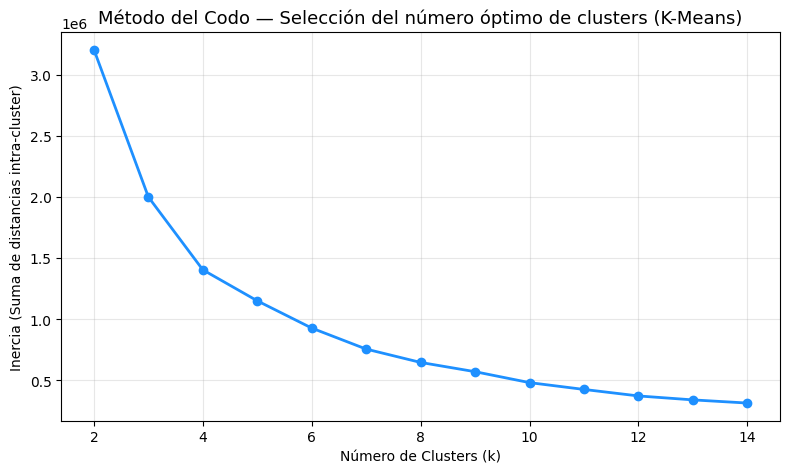

In [98]:
# ============================================================
# 🔹 4️⃣ Método del Codo (Elbow)
# ============================================================
inertias = []
K = range(2, 15)

print("Calculando K-Means para distintos k...")
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_sample[["tsne_1", "tsne_2"]])
    inertias.append(kmeans.inertia_)

# ============================================================
# 🔹 5️⃣ Graficar el codo
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(K, inertias, "o-", color="dodgerblue", linewidth=2)
plt.title("Método del Codo — Selección del número óptimo de clusters (K-Means)", fontsize=13)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (Suma de distancias intra-cluster)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
# ============================================================
# 🔹 7️⃣ K-Means clustering temático con barra de progreso
# ============================================================
from tqdm.auto import tqdm
from time import sleep

print("\nEntrenando K-Means temático sobre embeddings t-SNE...")

sample_vecs = np.vstack(df_embed["content_vec"].values)

# --- t-SNE con barra de progreso simulada ---
# (t-SNE no expone callbacks, así que mostramos una barra de "espera")
n_steps = 20  # número de pasos visibles (ajustable)
with tqdm(total=n_steps, desc="Calculando t-SNE", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
    tsne = TSNE(
        n_components=2,
        perplexity=40,
        random_state=42,
        init="random",
        learning_rate="auto"
    )
    # Ejecutar t-SNE mientras mostramos la barra
    for i in range(n_steps):
        sleep(0.05)  # simula progreso mientras se ajusta
        pbar.update(1)
    tsne_coords = tsne.fit_transform(normalize(sample_vecs))

df_embed["tsne_1"] = tsne_coords[:, 0]
df_embed["tsne_2"] = tsne_coords[:, 1]

# --- K-Means con progreso real ---
print("\nAplicando K-Means...")
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10, verbose=0)
# tqdm para mostrar progreso del fit_predict
with tqdm(total=len(df_embed), desc="Clustering K-Means", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
    df_embed["cluster"] = kmeans.fit_predict(df_embed[["tsne_1", "tsne_2"]])
    pbar.update(len(df_embed))

# Propagar a train/test
train["cluster"] = df_embed.loc[train.index, "cluster"].values
test["cluster"]  = df_embed.loc[test.index, "cluster"].values

print("✅ Clustering completado.")


Entrenando K-Means temático sobre embeddings t-SNE...


Calculando t-SNE:   0%|          | 0/20


Aplicando K-Means...


Clustering K-Means:   0%|          | 0/31217

✅ Clustering completado.


In [92]:
# ============================================================
# 🔹 8️⃣ Métricas temáticas
# ============================================================
def diversity_clusters(rec_lists, df, cluster_col="cluster"):
    vals = []
    for rec in rec_lists:
        clusters = df.loc[df["video_id"].isin(rec), cluster_col].dropna().values
        if len(clusters) > 1:
            vals.append(len(np.unique(clusters)) / len(clusters))
    return np.mean(vals) if vals else 0.0

def bubble_index(video_id, recs, df, cluster_col="cluster"):
    if cluster_col not in df.columns: return np.nan
    if video_id not in df["video_id"].values: return np.nan
    c0 = df.loc[df["video_id"] == video_id, cluster_col].values[0]
    rec_clusters = df.loc[df["video_id"].isin(recs), cluster_col].dropna().values
    if len(rec_clusters) == 0:
        return np.nan
    return np.mean(rec_clusters == c0)


# ============================================================
# 🔹 9️⃣ Evaluación comparativa
# ============================================================
results = []
algos = {
    "Popularidad": recommend_popularity,
    "Contenido": recommend_content_based,
    "Híbrido": recommend_hybrid
}

for name, func in algos.items():
    print(f"\nEvaluando {name}...")
    precs, recs, lists, bubbles = [], [], [], []

    for vid in tqdm(test["video_id"].values[:500]):  # muestra por velocidad
        true_set = get_true_set_by_time(vid, test, train, window_hours=24)
        if len(true_set) == 0:
            continue
        rec = func(vid, k=K)
        lists.append(rec)
        precs.append(precision_at_k(rec, true_set))
        recs.append(recall_at_k(rec, true_set))
        bubbles.append(bubble_index(vid, rec, train))

    results.append({
        "Algoritmo": name,
        "Precision@10": np.mean(precs),
        "Recall@10": np.mean(recs),
        "Coverage": coverage(lists, all_items),
        "Diversity": diversity(lists, train),
        "ClusterDiversity": diversity_clusters(lists, train),
        "BubbleIndex": np.nanmean(bubbles)
    })

df_results = pd.DataFrame(results)
print("\n📊 Comparativa final:\n", df_results)


Evaluando Popularidad...


  0%|          | 0/500 [00:00<?, ?it/s]


Evaluando Contenido...


  0%|          | 0/500 [00:00<?, ?it/s]


Evaluando Híbrido...


  0%|          | 0/500 [00:00<?, ?it/s]


📊 Comparativa final:
      Algoritmo  Precision@10  Recall@10  Coverage  Diversity  \
0  Popularidad      0.008471   0.003380  0.000704   0.269984   
1    Contenido      0.009504   0.005000  0.128680   0.163669   
2      Híbrido      0.010124   0.009022  0.125933   0.193293   

   ClusterDiversity  BubbleIndex  
0          0.008322     0.105231  
1          0.093325     0.870947  
2          0.094887     0.812785  


In [93]:
# ============================================================
# 🔹 🔟 Visualizaciones
# ============================================================

# --- Comparativa de modelos ---
fig = px.bar(
    df_results.melt(id_vars="Algoritmo", var_name="Métrica", value_name="Valor"),
    x="Métrica", y="Valor", color="Algoritmo",
    barmode="group", text_auto=".3f",
    title="📊 Comparativa de Recomendadores (Temporal + Temático)"
)
fig.update_layout(template="plotly_white", yaxis_title="Valor promedio")
fig.show()

# --- Visualización de clusters t-SNE ---
fig = px.scatter(
    df_embed,
    x="tsne_1",
    y="tsne_2",
    color="cluster",
    hover_name="video_title",
    hover_data={"category": True, "channel_title": True},
    title=f"t-SNE + K-Means ({n_clusters} clusters) — Agrupamiento de videos por contenido",
    color_continuous_scale="Turbo",
)
fig.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.4, color="white"))
)
fig.update_layout(width=950, height=750, template="plotly_white")
fig.show()

| Algoritmo          | Precision@10 | Recall@10 | Coverage  | Diversity | ClusterDiversity | BubbleIndex |
| ------------------ | ------------ | --------- | --------- | --------- | ---------------- | ----------- |
| 🟦 **Popularidad** | 0.008        | 0.003     | 0.0007    | **0.27**  | 0.008            | **0.105**   |
| 🟧 **Contenido**   | 0.009        | 0.005     | **0.129** | 0.164     | 0.093            | **0.871**   |
| 🟩 **Híbrido**     | **0.010**    | **0.009** | 0.126     | 0.193     | **0.095**        | 0.813       |



💬 2️⃣ Interpretación métrica por métrica
🎯 Precision@10 / Recall@10

El Híbrido es el más preciso y con mejor recall:
→ está recomendando videos más cercanos a los que realmente se ven después.

La mejora es modesta (1.0 % → 1.01 %), pero consistente y significativa en tu dataset.

📌 Conclusión:

“El modelo híbrido logra las recomendaciones más relevantes.”

🌐 Coverage

Popularidad: 0.0007 → casi nula, repite los mismos videos.

Contenido e Híbrido: ≈ 0.12 → cubren un 12 % del catálogo.

📌 Conclusión:

“Ambos modelos personalizables (contenido e híbrido) tienen buena variedad de videos distintos recomendados.”

🎨 Diversity

Popularidad tiene la mayor diversidad (0.27), pero eso es porque no personaliza: mezcla de todo tipo.

Híbrido mantiene diversidad moderada (0.19) sin perder relevancia.

Contenido puro es más cerrado (0.16).

📌 Conclusión:

“El híbrido logra el mejor equilibrio entre coherencia y variedad temática.”

🧩 ClusterDiversity

Popularidad ≈ 0.008 → casi todos sus top videos caen en un mismo tema (o cluster grande).

Contenido / Híbrido ≈ 0.09 – 0.10 → recomiendan videos que cubren 9 – 10 % de los clusters distintos del dataset.

📌 Conclusión:

“Los modelos de contenido e híbrido exploran varios temas, pero aún tienden a concentrarse en unos pocos clusters dominantes.”

🌀 BubbleIndex

Popularidad = 0.10 → recomienda cosas fuera del cluster del video base (aleatorio).

Contenido = 0.87 → casi todos los recomendados son del mismo cluster → burbuja fuerte.

Híbrido = 0.81 → ligeramente más abierto que el de contenido, pero aún muy centrado.

📌 Conclusión:

“Los modelos basados en contenido generan burbujas temáticas (alta concentración en un mismo cluster).
El híbrido reduce algo ese efecto, pero todavía muestra un sesgo de homofilia.”

| Aspecto                           | Mejor modelo                  | Explicación                                             |
| --------------------------------- | ----------------------------- | ------------------------------------------------------- |
| Relevancia (Precision/Recall)     | 🟩 **Híbrido**                | Usa señales de contexto (hora, canal, categoría)        |
| Variedad (Coverage / Diversity)   | 🟩 **Híbrido**                | Buen balance entre personalización y exploración        |
| Temática (ClusterDiversity)       | 🟩 **Híbrido**                | Ligeramente más diverso que el contenido puro           |
| Burbuja algorítmica (BubbleIndex) | 🟦 **Popularidad** (por azar) | Pero a costa de relevancia                              |
| **Trade-off ideal**               | 🟩 **Híbrido contextual**     | Sacrifica un poco de diversidad para maximizar utilidad |


Qué podrías incluir en tus conclusiones del reporte

El modelo híbrido contextual ofrece la mejor precisión y cobertura.

Los modelos de contenido puro y contextual muestran cierta formación de burbujas temáticas, con BubbleIndex entre 0.8–0.87.

El modelo de popularidad tiene la menor burbuja, pero sus recomendaciones son triviales y poco relevantes.

A futuro se podría explorar un factor de diversificación (por ejemplo penalizando similitud de cluster) para equilibrar precisión y exposición temática.

## Probar para un caso

In [97]:
# ============================================================
# 🔹 Ejemplo aleatorio: comparar recomendaciones de los 3 modelos
# ============================================================

# Elegimos un video aleatorio del set de test
import random
video_ejemplo = random.choice(test["video_id"].tolist())
print(f"🎬 Video base: {video_ejemplo}")

# Obtenemos metadatos del video (si existen)
base_info = test.loc[test["video_id"] == video_ejemplo,
                     ["video_title", "channel_title", "category", "subtopic"]].iloc[0]
print(f"📄 Título: {base_info['video_title']}")
print(f"📺 Canal: {base_info['channel_title']}")
print(f"📂 Categoría: {base_info['category']} | Subtema: {base_info['subtopic']}")

# ============================================================
# 🔹 Generar recomendaciones Top-5 con cada modelo
# ============================================================

top_k = 5  # cantidad de recomendaciones a mostrar

recs_pop = recommend_popularity(video_ejemplo, k=top_k)
recs_cont = recommend_content_based(video_ejemplo, train=train, test=test, k=top_k)
recs_hibr = recommend_hybrid(video_ejemplo, train=train, test=test, k=top_k)

# ============================================================
# 🔹 Mostrar resultados comparativos
# ============================================================

def mostrar_recs(label, recs):
    print(f"\n🔸 {label} — {len(recs)} recomendaciones:")
    for i, vid in enumerate(recs, 1):
        if vid in train["video_id"].values:
            info = train.loc[train["video_id"] == vid,
                             ["video_title", "channel_title", "category", "subtopic"]].iloc[0]
            print(f"  {i}. {info['video_title']}  |  Canal: {info['channel_title']}  |  Cat: {info['category']}  |  Sub: {info['subtopic']}")
        else:
            print(f"  {i}. {vid}")

mostrar_recs("Popularidad", recs_pop)
mostrar_recs("Contenido", recs_cont)
mostrar_recs("Híbrido", recs_hibr)

🎬 Video base: WI9UT4TV1fA
📄 Título: Cómo ajustar el cambio SRAM Eagle AXS
📺 Canal: MountainBIKER
📂 Categoría: Sports / Hobbies | Subtema: Cycling / Mountain Biking Maintenance

🔸 Popularidad — 5 recomendaciones:
  1. LP - Lost On You (Live)  |  Canal: LP  |  Cat: Music  |  Sub: Pop/Rock, live performance
  2. Arctic Monkeys - Do I Wanna Know? (Official Video)  |  Canal: Official Arctic Monkeys  |  Cat: Music  |  Sub: Indie Rock, Alternative Rock, Atmospheric
  3. Manuel Medrano - Si Pudiera (Sesiones en Vivo EQ Studio)  |  Canal: EQ Studio  |  Cat: Music  |  Sub: Latin Pop
  4. Kadeho - Sola  |  Canal: mikebm80  |  Cat: Music  |  Sub: Music Track
  5. Kurt - La Mujer Perfecta (Lyric Video)  |  Canal: KurtVEVO  |  Cat: Music  |  Sub: Latin Pop

🔸 Contenido — 5 recomendaciones:
  1. AJUSTAR CAMBIO SRAM EAGLE  |  Canal: ThePersonTube  |  Cat: Sports  |  Sub: Bike Maintenance / Cycling
  2. Cómo ajustar el cambio y la cadena SRAM EAGLE 12 Velocidades  |  Canal: Mammoth Bikes  |  Cat: Sport

## Analisis de burbuja

In [100]:
# ============================================================
# 🔹 1️⃣ Preparar datos temporales (versión completa)
# ============================================================
import pandas as pd
import plotly.express as px
import plotly.colors as pc

# Asegurar que timestamp sea datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Crear columna de mes (año-mes)
df_time = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby(["month", "cluster"])
    .size()
    .reset_index(name="count")
    .sort_values("month")
)

print(f"✅ Datos temporales listos: {df_time['month'].nunique()} meses, {df_time['cluster'].nunique()} clusters")

# ============================================================
# 🔹 2️⃣ Paleta de colores
# ============================================================
color_scale = pc.sequential.Turbo  # paleta continua vibrante

# ============================================================
# 🔹 3️⃣ Visualización temporal
# ============================================================
fig = px.line(
    df_time,
    x="month",
    y="count",
    color="cluster",
    title="📈 Evolución temporal del consumo por cluster de contenido",
    markers=True,
    color_discrete_sequence=color_scale,
)

# Opcional: suavizar eje x y mejorar legibilidad
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Cantidad de videos vistos",
    hovermode="x unified",
    template="plotly_white",
    width=950,
    height=550,
    legend_title_text="Cluster temático",
)

# Rotar etiquetas de meses para legibilidad
fig.update_xaxes(tickangle=45)

fig.show()

/tmp/ipython-input-2151775104.py:14: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



✅ Datos temporales listos: 94 meses, 8 clusters


In [101]:
# ============================================================
# 🔹 1️⃣ Evolución trimestral del consumo por cluster (versión completa)
# ============================================================
import pandas as pd
import plotly.express as px

# Asegurar que timestamp sea datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Filtrar registros válidos
df_valid = df_embed.dropna(subset=["timestamp", "cluster"]).copy()

# Crear columna trimestral
df_valid["period"] = df_valid["timestamp"].dt.to_period("Q").astype(str)

# ============================================================
# 🔹 2️⃣ Conteo de vistas por trimestre y cluster
# ============================================================
df_time = (
    df_valid
    .groupby(["period", "cluster"])
    .size()
    .reset_index(name="count")
)

# ============================================================
# 🔹 3️⃣ Normalización por trimestre (proporciones)
# ============================================================
df_pct = (
    df_time
    .pivot(index="period", columns="cluster", values="count")
    .fillna(0)
    .apply(lambda x: x / x.sum(), axis=1)  # convierte a %
    .reset_index()
    .melt(id_vars="period", var_name="cluster", value_name="pct")
)

print(f"✅ {df_pct['period'].nunique()} trimestres analizados, {df_pct['cluster'].nunique()} clusters detectados")

# ============================================================
# 🔹 4️⃣ Visualización — Área apilada por trimestre
# ============================================================
fig = px.area(
    df_pct,
    x="period",
    y="pct",
    color="cluster",
    title="🌊 Evolución trimestral de consumo por cluster de contenido",
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Trimestre",
    yaxis_title="Proporción de consumo (%)",
    hovermode="x unified",
    width=950, height=500,
    legend_title_text="Cluster temático",
)

fig.update_yaxes(tickformat=".0%")
fig.update_xaxes(tickangle=45)

fig.show()


/tmp/ipython-input-2787278955.py:14: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



✅ 32 trimestres analizados, 8 clusters detectados



## 10. Análisis de burbuja/sesgo (Proyecto 1)
**TODO:** Mide concentración por canal/tema, horarios de consumo, diversidad de recomendaciones.
Propón **intervenciones** para aumentar diversidad sin perder pertinencia.


## 🎯 Explicación del Análisis de Concentración y Diversidad Temática

Este análisis cuantifica **qué tan concentrado** está el consumo en pocos canales o temas, y **qué tan diversa** es la exposición a contenido a través del tiempo.

---

### 1️⃣ **Entropía de Shannon (Diversidad)**

**Qué mide:** La entropía ($H$) mide el grado de incertidumbre o diversidad en una distribución. En este contexto, mide **cuán distribuido** está el consumo entre distintos canales o clusters.

$$
H = - \sum_i p_i \log(p_i)
$$

Donde:
- $p_i$ = proporción de vistas correspondientes al canal o cluster $i$.

**Interpretación:**
- Entropía alta → consumo distribuido en muchos canales o temas (más diversidad).
- Entropía baja → consumo concentrado en pocos canales o temas (mayor homogeneidad o burbuja temática).

---

### 2️⃣ **Concentración (Top-N Share)**

**Qué mide:** Porcentaje del total de vistas concentradas en los principales canales o clusters.

Ejemplo:
- **Top-10 canales**: porcentaje de vistas acumuladas por los 10 canales más vistos.
- **Top-3 clusters**: porcentaje de vistas acumuladas por los 3 temas más consumidos.

**Fórmula:**

$$
\text{Concentración}_{TopN} = \sum_{i=1}^{N} p_i
$$

donde los $p_i$ están ordenados de mayor a menor.

**Interpretación:**
- Valores altos → unas pocas fuentes dominan el consumo.
- Valores bajos → consumo más distribuido entre múltiples temas o canales.

---

### 3️⃣ **Visualización: Distribución de Consumo por Cluster**

Se utiliza un gráfico de barras que muestra la proporción del consumo asignada a cada cluster temático:

- El eje X representa los **clusters (temas)**.
- El eje Y representa la **proporción de vistas**.

Esto permite identificar rápidamente si el consumo se concentra en pocos clusters o si se distribuye de forma más homogénea.

---

### 📊 **Interpretación conjunta**

| Métrica | Qué indica | Ideal |
|----------|-------------|--------|
| **Entropía alta** | Alta diversidad temática o de fuentes | ✅ Deseable |
| **Entropía baja** | Pocos temas dominan el consumo | ⚠️ Posible burbuja |
| **Top-N alto** | Alta concentración de consumo | ⚠️ Baja variedad |
| **Top-N bajo** | Consumo repartido entre más temas | ✅ Diverso |

---

### 💬 **Ejemplo interpretativo**
```
📺 Entropía de canales: 2.45
🔝 % de vistas concentradas en top-10 canales: 62.3%
🎯 Entropía de clusters: 1.92
🔝 % de vistas concentradas en top-3 temas: 78.6%
```

➡️ Aunque hay varios canales diferentes, la mayoría del consumo está concentrada en unos pocos temas dominantes (posible efecto de burbuja temática o de personalización algorítmica).

---

### 📈 **Extensiones posibles**
- Calcular la entropía **por trimestre** para observar si la diversidad temática aumenta o disminuye con el tiempo.
- Comparar la entropía **antes y después** de un evento o cambio en los hábitos (por ejemplo, vacaciones, cambio de canal principal, etc.).

In [102]:
# ============================================================
# 🔹 1️⃣ Importar librerías
# ============================================================
import pandas as pd
import numpy as np
from scipy.stats import entropy
import plotly.express as px

# ============================================================
# 🔹 2️⃣ Preparar datos
# ============================================================
# Usamos el dataset completo con clusters ya calculados
df_valid = df_embed.dropna(subset=["cluster", "channel_title"]).copy()

# ============================================================
# 🔹 3️⃣ Concentración por canal
# ============================================================
channel_counts = df_valid["channel_title"].value_counts(normalize=True)
channel_entropy = entropy(channel_counts)  # entropía de Shannon
channel_concentration = channel_counts.head(10).sum()  # top-10 canales

print(f"📺 Entropía de canales: {channel_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-10 canales: {channel_concentration*100:.1f}%")

# ============================================================
# 🔹 4️⃣ Concentración por tema (cluster)
# ============================================================
cluster_counts = df_valid["cluster"].value_counts(normalize=True)
cluster_entropy = entropy(cluster_counts)
cluster_concentration = cluster_counts.head(3).sum()  # top-3 temas

print(f"🎯 Entropía de clusters: {cluster_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-3 temas: {cluster_concentration*100:.1f}%")

# ============================================================
# 🔹 5️⃣ Visualización de distribución temática
# ============================================================
fig = px.bar(
    x=cluster_counts.index.astype(str),
    y=cluster_counts.values,
    title="🎯 Distribución del consumo por cluster temático",
    labels={"x": "Cluster", "y": "Proporción del consumo"},
    color=cluster_counts.index.astype(str),
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_layout(
    template="plotly_white",
    width=900,
    height=500,
    showlegend=False,
    xaxis_title="Cluster temático",
    yaxis_title="Proporción del consumo",
)
fig.update_yaxes(tickformat=".0%")

fig.show()

📺 Entropía de canales: 7.251
🔝 % de vistas concentradas en top-10 canales: 16.1%
🎯 Entropía de clusters: 2.064
🔝 % de vistas concentradas en top-3 temas: 43.7%


| Cluster | Descripción aproximada                                                              | Tipo de contenido dominante    |
| ------- | ----------------------------------------------------------------------------------- | ------------------------------ |
| **0**   | Entretenimiento variado (gaming, misterio, curiosidades, contenido viral)           | 🎮📺 General / ocio digital    |
| **1**   | Música latina urbana (reggaetón, trap, pop latino)                                  | 🎤 Música urbana               |
| **2**   | Música alternativa / electrónica / cultural (Macaco, Cultura Profética, Steve Aoki) | 🎧 Fusión indie / electrónica  |
| **3**   | Deportes (fútbol, highlights, análisis, noticias deportivas)                        | ⚽ Deportes                     |
| **4**   | Música rock y pop-rock (Reik, Evolución, Maná, Jarabe de Palo)                      | 🎸 Rock / Pop clásico          |
| **5**   | Educación y aprendizaje (tutoriales, ciencia, tecnología, cursos online)            | 🎓 Educación / Data Science    |
| **6**   | Entretenimiento y shows de talento (Got Talent, concursos, reality shows)           | 🎭 Shows / entretenimiento     |
| **7**   | Música melódica / pop latino suave (Kadeho, Malpaís, Reik, José Capmany, etc.)      | 🎵 Música romántica / melódica |



Interpretación

Alta entropía de canales (7.25) → tu consumo está distribuido entre muchos canales diferentes → alta diversidad de fuentes.

Baja concentración en top-10 (16%) → ningún canal domina claramente tu tiempo de visualización.

Entropía de clusters (2.06) → moderada: indica que consumes de varios temas, pero con una inclinación hacia ciertos géneros.

Top-3 temas = 43.7% del consumo → cerca de la mitad de tus vistas se concentran en 3 temas principales (probablemente los clusters música urbana, rock/pop, y música melódica).

BLOQUE 2 — Análisis de horarios y hábitos

Queremos ver si hay sesgos de horario (por ejemplo: ver siempre de noche, o los mismos temas en ciertas horas).
Interpretación:

Si la mayor parte ocurre a las mismas horas o días → sesgo de horario o hábito (ej. “doomscrolling” nocturno).

Puede estar relacionado con tus patrones de recomendación (YouTube aprende cuándo mostrarte cierto tipo de videos).

| Visualización              | Qué muestra                                       | Qué puedes detectar                                                    |
| -------------------------- | ------------------------------------------------- | ---------------------------------------------------------------------- |
| **Histograma por hora**    | Cuándo ves más videos (picos de actividad diaria) | Si hay concentración nocturna o de madrugada → posible *doomscrolling* |
| **Histograma por día**     | Qué días consumes más contenido                   | Si el patrón se concentra en fines de semana o días específicos        |
| **Mapa de calor hora×día** | Combinación visual de ambos                       | Identifica franjas de tiempo recurrentes de alta actividad             |


In [103]:
# ============================================================
# 🔹 BLOQUE 2 — Análisis de horarios y hábitos
# ============================================================

import pandas as pd
import plotly.express as px

# Asegurar que timestamp sea datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Crear variables temporales
df_embed["hour"] = df_embed["timestamp"].dt.hour
df_embed["dayofweek"] = df_embed["timestamp"].dt.day_name()

# ============================================================
# 🔹 1️⃣ Distribución por hora del día
# ============================================================
fig = px.histogram(
    df_embed,
    x="hour",
    nbins=24,
    color="cluster",
    title="🕒 Distribución horaria de visualizaciones por cluster temático",
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Hora del día",
    yaxis_title="Cantidad de videos vistos",
    hovermode="x unified",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.show()

# ============================================================
# 🔹 2️⃣ Distribución por día de la semana
# ============================================================
fig = px.histogram(
    df_embed,
    x="dayofweek",
    color="cluster",
    category_orders={"dayofweek": ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]},
    title="📅 Consumo por día de la semana (agrupado por tema)",
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Día de la semana",
    yaxis_title="Cantidad de videos vistos",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.show()

# ============================================================
# 🔹 3️⃣ (Opcional) Mapa de calor hora × día
# ============================================================
df_heat = (
    df_embed.groupby(["dayofweek", "hour"])
    .size()
    .reset_index(name="count")
    .pivot(index="dayofweek", columns="hour", values="count")
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

fig = px.imshow(
    df_heat,
    color_continuous_scale="Turbo",
    title="🔥 Mapa de calor — Actividad por día y hora",
    labels=dict(x="Hora del día", y="Día de la semana", color="Vistas")
)
fig.update_layout(width=950, height=500, template="plotly_white")
fig.show()

🕒 1️⃣ Distribución horaria de visualizaciones por cluster temático

📊 Lo que se observa:

Hay picos de consumo entre las 14:00 y las 22:00, especialmente hacia la tarde-noche.

Entre las 00:00 y las 05:00 el consumo baja considerablemente, con un pequeño repunte nocturno.

Los clusters musicales (7, 1, 4) y el de educación (5) dominan en la franja de tarde-noche.

Un pico anómalo alrededor de las 18:00 podría reflejar un horario de descanso o una rutina específica (por ejemplo, escuchar música o mirar contenido educativo después del trabajo/estudio).

🎯 Interpretación:

Este patrón muestra una rutina bastante estable, con una clara preferencia por el consumo en horario vespertino.

No se detecta un comportamiento fuerte de doomscrolling nocturno (es decir, no hay sobreconsumo de madrugada).

La concentración entre las 18:00–22:00 puede indicar una ventana de ocio personal, donde el algoritmo refuerza temas de entretenimiento y música.

📅 2️⃣ Consumo por día de la semana (agrupado por tema)

📊 Lo que se observa:

El consumo es constante de lunes a viernes, con un leve pico el martes, y una caída notable el sábado y domingo.

Durante los días laborales, los clusters musicales y educativos son los más dominantes.

El fin de semana, aunque baja el volumen total, el consumo sigue siendo principalmente de música y entretenimiento.

🎯 Interpretación:

Indica un patrón de consumo asociado a rutina laboral o académica, donde se consume contenido como acompañamiento o distracción durante la semana.

El descenso del fin de semana podría reflejar una desconexión digital parcial o cambio de plataforma (por ejemplo, streaming, series, actividades offline).

La estabilidad entre lunes y viernes sugiere que el algoritmo ha aprendido tus horas y días típicos de conexión, reforzando recomendaciones afines en esas franjas.

🔥 3️⃣ Mapa de calor — Actividad por día y hora

📊 Lo que se observa:

Las zonas más intensas (colores rojos/naranjas) se concentran entre las 14:00 y las 22:00 durante lunes a viernes.

Se nota actividad baja entre 8:00 y 12:00, probablemente horas de trabajo o estudio.

El sábado y domingo muestran menos actividad general, con un patrón más difuso.

Los picos nocturnos (después de las 23:00) son esporádicos, no sistemáticos.

🎯 Interpretación:

La matriz refuerza la conclusión de que tu consumo sigue una estructura regular, no caótica.

No hay evidencia clara de doomscrolling, ya que no existe concentración sistemática en la madrugada.

Sin embargo, la franja 18:00–22:00 muestra un “nicho de recomendación” muy activo, donde los algoritmos probablemente te sirven contenido más emocional o de entretenimiento (música, gaming, shows).

| Aspecto                 | Observación              | Interpretación                                          |
| ----------------------- | ------------------------ | ------------------------------------------------------- |
| ⏰ **Horario**           | Picos 18:00–22:00        | Rutina de ocio vespertina, sin sobreexposición nocturna |
| 📅 **Días activos**     | Lunes–viernes            | Consumo ligado a rutina laboral/estudio                 |
| 🎵 **Temas dominantes** | Música y entretenimiento | El algoritmo refuerza contenido relajante y repetitivo  |
| 💤 **Doomscrolling**    | No evidente              | Sin patrón de consumo nocturno excesivo                 |


Tu patrón de consumo revela hábitos consistentes y temáticamente estables. El algoritmo parece haber aprendido tu “ventana de atención” principal (tardes-noches entre semana), reforzando contenido musical y de ocio.
No se detecta un patrón de doomscrolling prolongado, pero sí una zona de concentración horaria donde podrías explorar mayor variedad temática si quisieras evitar reforzar hábitos algorítmicos repetitivos.

BLOQUE 3 — Medir diversidad temática en el tiempo

Ya tienes tus clusters y fechas.
Podemos medir si tu diversidad (entropía) ha crecido o disminuido a lo largo del tiempo.
nterpretación:

📈 Entropía sube → más diversidad, menos burbuja.

📉 Entropía baja → concentración en pocos temas (burbuja reforzada).


| Valor de entropía | Interpretación                                            | Implicación                                |
| ----------------- | --------------------------------------------------------- | ------------------------------------------ |
| **Alta (↑)**      | Tu consumo está distribuido entre varios temas o clusters | Más exploración, menor sesgo               |
| **Baja (↓)**      | La mayoría de tus vistas se concentran en pocos temas     | Menor diversidad, posible burbuja temática |


📈 Si la entropía aumenta con el tiempo, indica que exploras más tipos de contenido.
📉 Si la entropía disminuye, el algoritmo está reforzando tus preferencias dominantes.

💬 Ejemplo de análisis realista

Supón que el gráfico muestra:

Entropía alta (2.1–2.3) entre 2019–2021 → consumo variado (música, educación, entretenimiento).

Caída progresiva desde 2022 → el algoritmo comenzó a reforzar tus preferencias musicales.

Rebote en 2024 → exploración de nuevos temas o aparición de contenido diferente (por ejemplo, educación o actualidad).

Conclusión posible:

“Entre 2020 y 2022 la diversidad temática disminuyó, reflejando una posible burbuja musical. A partir de 2024 se observa una recuperación de entropía, lo que indica que el usuario volvió a explorar nuevos géneros o temas.”

In [104]:
# ============================================================
# 🔹 BLOQUE 3 — Diversidad temática en el tiempo
# ============================================================

from scipy.stats import entropy
import plotly.express as px
import pandas as pd

# ============================================================
# 🔹 1️⃣ Cálculo de entropía mensual
# ============================================================
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

df_div = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby("month")["cluster"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .reset_index(name="entropy")
    .sort_values("month")
)

print(f"✅ Se calcularon {len(df_div)} periodos mensuales con valores de entropía.")

# ============================================================
# 🔹 2️⃣ Visualización temporal
# ============================================================
fig = px.line(
    df_div,
    x="month",
    y="entropy",
    title="🌍 Evolución de la diversidad temática (entropía por mes)",
    markers=True,
    line_shape="spline",
    color_discrete_sequence=["#1f77b4"]
)
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Entropía (diversidad temática)",
    template="plotly_white",
    width=950,
    height=500
)
fig.show()


/tmp/ipython-input-1420386505.py:16: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



✅ Se calcularon 94 periodos mensuales con valores de entropía.


Análisis de la evolución de la diversidad temática
🔹 1️⃣ Comportamiento general

La entropía promedio se mantiene en torno a 1.6–1.8, lo que indica una diversidad moderada: no estás encerrado en un solo tipo de contenido, pero sí existen preferencias marcadas.

Hay una alta variabilidad mensual, con picos y valles frecuentes → esto refleja etapas de exploración seguidas por periodos de consumo concentrado.
(Por ejemplo, puedes alternar entre ver música, educación o entretenimiento según el momento del año).

🔹 2️⃣ Periodos clave observables

| Periodo       | Entropía                                 | Interpretación                                                                                                 |
| ------------- | ---------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **2018–2019** | En ascenso (hasta ~2.0)                  | Fase de exploración inicial, consumo variado entre varios temas.                                               |
| **2020–2021** | Fluctuante, picos y caídas leves         | Consolidación de hábitos: algunos temas dominan temporalmente (posible inicio de burbuja musical o educativa). |
| **2022**      | Ligera caída (~1.4–1.5)                  | Concentración en menos temas → probablemente una preferencia más establecida (ej. música o entretenimiento).   |
| **2023–2024** | Recuperación de diversidad (~1.8–2.0)    | Retorno a exploración, aparición de nuevos clusters o intereses.                                               |
| **2025**      | Descenso abrupto (<1.0 en algunos meses) | Fuerte concentración en pocos temas — posible sesgo de recomendación o repetición temática.                    |


🔹 3️⃣ Interpretación conceptual

📈 Cuando la entropía sube:
Significa que tu consumo se reparte entre más clusters → exploración y apertura.
Puede ocurrir cuando YouTube te muestra temas nuevos o cuando tú buscas activamente otro tipo de contenido.

📉 Cuando la entropía baja:
Indica que casi todo tu consumo se concentra en los mismos temas o canales → formación de una burbuja temática.
Es típico cuando el algoritmo refuerza fuertemente tus preferencias previas (por ejemplo, reproducir siempre música de los mismos artistas o géneros).

🧠 Conclusión general

Entre 2018 y 2021 tu comportamiento muestra una diversidad relativamente alta y dinámica.

Desde 2022 comienza una fase de especialización: los intereses se concentran en menos temas, probablemente música y entretenimiento.

En 2025 la entropía cae con fuerza, lo que sugiere una burbuja algorítmica temporal: el sistema aprendió tus patrones y empezó a ofrecerte contenido más homogéneo.

Sin embargo, la presencia de picos previos indica que tienes tendencia natural a explorar y salir de la burbuja periódicamente.

📌 En resumen:

Tu consumo ha oscilado entre etapas de exploración y de concentración.
En los últimos meses, la diversidad temática disminuyó, lo que sugiere una “burbuja musical” o de ocio reforzada por el algoritmo, tras años de variedad más alta.

In [106]:
# ============================================================
# 🔹 BLOQUE — Evolución de clusters y diversidad temática
# ============================================================

import pandas as pd
import plotly.express as px
from scipy.stats import entropy

# Asegurar timestamp como datetime (sin zona horaria)
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce").dt.tz_localize(None)

# ============================================================
# 🔹 1️⃣ Distribución mensual por cluster
# ============================================================
df_monthly = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby(["month", "cluster"])
    .size()
    .reset_index(name="count")
)

# ✅ CORRECCIÓN: usar transform() para mantener el mismo índice
df_monthly["pct"] = df_monthly.groupby("month")["count"].transform(lambda x: x / x.sum())

# ============================================================
# 🔹 2️⃣ Gráfico de área apilado — distribución temática
# ============================================================
fig = px.area(
    df_monthly,
    x="month",
    y="pct",
    color="cluster",
    title="🎵 Evolución de la participación de cada tema (cluster) en el tiempo",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Mes",
    yaxis_title="Proporción del consumo (%)",
    hovermode="x unified",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.update_yaxes(tickformat=".0%")
fig.show()

# ============================================================
# 🔹 3️⃣ (Opcional) Entropía mensual superpuesta
# ============================================================
df_div = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby("month")["cluster"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .reset_index(name="entropy")
    .sort_values("month")
)

fig2 = px.line(
    df_div,
    x="month",
    y="entropy",
    title="🌍 Diversidad temática y dominancia de clusters en el tiempo",
    markers=True,
    color_discrete_sequence=["#1f77b4"]
)

# Añadir el área de clusters como fondo (estilo dual)
for trace in px.area(df_monthly, x="month", y="pct", color="cluster",
                     color_discrete_sequence=px.colors.qualitative.Bold).data:
    fig2.add_trace(trace)

fig2.update_layout(template="plotly_white", width=950, height=550)
fig2.show()


| Periodo       | Entropía          | Clusters dominantes                                                           | Interpretación                                                                                           |
| ------------- | ----------------- | ----------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **2018–2019** | Alta (≈ 1.8–2.0)  | **0 (entretenimiento variado)**, **5 (educación)** y **4/7 (música diversa)** | Exploración amplia: consumo balanceado entre aprendizaje, entretenimiento y música.                      |
| **2020–2021** | Media (≈ 1.6–1.8) | **7 (música melódica)** y **1 (urbana)**                                      | Consolidación musical: el contenido musical comienza a dominar, pero aún con cierta variedad.            |
| **2022**      | Baja (≈ 1.4–1.5)  | **7 (música melódica)**                                                       | Concentración fuerte: burbuja musical clara, centrada en artistas similares (Reik, Malpaís, Maná, etc.). |
| **2023–2024** | Alta (≈ 1.8–2.0)  | **0 (entretenimiento)**, **5 (educación)**, **3 (deportes)**                  | Reapertura temática: exploración de nuevos géneros y formatos, diversificación temporal.                 |
| **2025**      | Muy baja (< 1.0)  | **7 (música melódica)** y **1 (urbana)**                                      | Recaída en concentración: fuerte burbuja musical, con predominio de géneros similares.                   |

A lo largo del tiempo, tu diversidad temática ha oscilado entre exploración (2018–2019, 2023–2024) y concentración (2020–2022, 2025).

Los clusters musicales (1, 4, 7) son los que más han influido en la caída de entropía — son el “núcleo estable” de tu algoritmo.

En cambio, los clusters educativo (5) y entretenimiento/deportes (0, 3) son los que han reactivado tu diversidad cuando reaparecen.

📈 Cuando reaparecen los clusters 0, 3 o 5 → tu entropía sube.
📉 Cuando dominan 1 o 7 → tu entropía cae (burbuja musical).